# Attractant Dynamics Parameters

This notebook allows you to expermiment with how different attractant dynamics parameters create different levels of observed bias in different points in space and time. The model goes something like this:

The heat equation gives us a solution to calculate the concentration of attractant at any point $r$ and $t$ in space. It takes parameters $q$, $D$ and $\tau$, which represent the flow rate, the diffusion coefficient and the diffusion time respectively. This is then used, along with the theory of receptir-lingand binding kinetics, to predict the number of bound complexes that should appear on either side of a migrating leukocyte. This equation takes parameters $R_0$ and $\kappa_d$. Finally, the observed bias of a cell at time $t$ a distance $r$ from the wound is assumed to be linearly related to the difference between the concentration of bound receptors at the front and rear of the cell. 

This means, given a set of parameters $\theta = \{q, \, D, \, \tau, \, R_0, \, \kappa_d, \, m, \, b_0\}$, we can calculate the observed bias one would expect to occur at any point in space and time. 



In [1]:
# Import all the necessary modules needed to run the inference pipeline
import sys
import os

sys.path.append(os.path.abspath('..'))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 
from inference.attractant_inference import AttractantInferer
from in_silico.sources import PointWound
import emcee
from Utilities.distributions import Uniform, TruncatedNormal


In [2]:
filesuffix = "_excluding_e2e_lt30"

ob_readings_control = {}
ob_readings_mcr = {}

distance = [54, 105, 195, 305, 430] # Liepe bins: [54, 105, 195, 305, 430]; 2x bins: [54, 87.5, 122.5, 167.5, 222.5, 277.5, 332.5, 395]
time = [2.5,7.5,12.5,17.5,22.5]
time_labels = ["0-5","5-10","10-15","15-20","20-25"]
stepSizeTimeBins = 1
if stepSizeTimeBins==2: # because np.round will round 4.5 to 4 (to the nearest even number...)
    nTimeBins = int(np.round(len(time_labels)/stepSizeTimeBins))+1
elif stepSizeTimeBins==1:
    nTimeBins = int(np.round(len(time_labels)/stepSizeTimeBins))

burnin_BP= 3000
thin_BP= 40

# This function reads in previously run data from walker inference pipeline, and outputs the observed bias mean and std\
# for the dataframe. The inputs are x,y which correspond to the file formats
def bias_param_samples_from_file(emcee_samples):
    # Removes the burn-in, thins the posterior data and flattens the walkers into a single array
    flattened_chain = emcee_samples.get_chain(discard=burnin_BP, thin=thin_BP, flat=True)
    w = flattened_chain[:, 0]  # The weighting parameter from the walker posterior array
    # p = flattened_chain[:, 1]  # The weighting parameter from the walker posterior array
    b = flattened_chain[:, 2]  # The bias parameter from the walker posterior array
    observedBias = w * b  # The observed bias parameter from the walker posterior array
    # observedPersistence = (1 - w) * p  # The observed persistence parameter from the walker posterior array
    mean_ob = np.mean(observedBias)
    std_ob = np.std(observedBias)
    # mean_op = np.mean(observedPersistence)
    # std_op = np.std(observedPersistence)
    return mean_ob, std_ob#, mean_op, std_op

def bias_values_control(i, j): 
    control_data = emcee.backends.HDFBackend('../data/BP_inference/Single_wound_CTR_revision'+filesuffix+'_bins{}{}.h5'.format(i,j))
    return bias_param_samples_from_file(control_data)

def bias_values_mcr(i, j): 
    mcr_data = emcee.backends.HDFBackend('../data/BP_inference/Single_wound_MCR_revision'+filesuffix+'_bins{}{}.h5'.format(i,j))
    return bias_param_samples_from_file(mcr_data)

"""
Here we define a nested for loop which populates the dictionary ob_readings with the mean and std of the current 
observed bias. This is then ready to be read into our attractant inference as the data for the inference pipeline. 
"""
for i in range(nTimeBins):
    for j in range(len(distance)):
        ObBias_cont = bias_values_control(j, i*stepSizeTimeBins)
        ObBias_mcr = bias_values_mcr(j, i*stepSizeTimeBins)

        ob_mean_cont = ObBias_cont[0]
        ob_std_cont = ObBias_cont[1]
        
        ob_mean_mcr = ObBias_mcr[0]
        ob_std_mcr = ObBias_mcr[1]
        ob_readings_control[(distance[j], time[i*stepSizeTimeBins])] = (ob_mean_cont, ob_std_cont)
        ob_readings_mcr[(distance[j], time[i*stepSizeTimeBins])] = (ob_mean_mcr, ob_std_mcr)

In [5]:
n_walkers = 40
n_iter = 10000
priors = [Uniform(0,3500), # q # Reference: Liepe, Taylor, et al. 2012 have a 1D diffusion model with amplitude parameter U[0,1000] over 1.5hrs or more, per unit length, so we estimate 1000/90mins * wound circumference (here max 100 microns diameter) to be the upper bound for q
        TruncatedNormal(200, 50), #Uniform(64,1000), #TruncatedNormal(200, 50), # D # Reference: Weavers, Liepe, et al. 2016 Fig. 3C
        TruncatedNormal(18, 3), #Uniform(0,25), # τ # Reference: Weavers, Liepe, et al. 2016 Fig. 3D
        Uniform(0, 10000), # R0 # Reference: Liepe, Taylor, et al. 2012 Table 1
        Uniform(0, 10000), # κ # Reference: Liepe, Taylor, et al. 2012 Table 1
        Uniform(0, 100), # m 
        TruncatedNormal(0.02, 0.02)] # b0 # Reference: Weavers, Liepe, et al. 2016 Fig. 3E

# Sets the wound location
wound = PointWound(position=np.array([0, 0]))

import multiprocessing as mp
mp.set_start_method('fork', force=True)
inferer_cont = AttractantInferer(ob_readings_control,priors=priors, wound=wound, t_units='minutes')
# Emcee (Ensemble Monte Carlo)
Post_attractant_control = inferer_cont.ensembleinfer(n_walkers, n_iter, Pooling = True)

  0%|          | 6/10000 [00:00<02:53, 57.66it/s]

Running sampler with pooling: 


  6%|▌         | 579/10000 [00:09<02:33, 61.27it/s]


KeyboardInterrupt: 

In [65]:
# # This saves the Emcee output to the data folder
# np.save('../data/Attractant_inference/Attractant_CTR_revision', Post_attractant_control)

In [66]:
n_walkers = 50
n_iter = 10000

# Sets the wound location
wound = PointWound(position=np.array([0, 0]))
inferer_mcr = AttractantInferer(ob_readings_mcr,priors=priors, wound=wound, t_units='minutes')
# Emcee (Ensemble Monte Carlo)
Post_attractant_mcr = inferer_mcr.ensembleinfer(n_walkers, n_iter, Pooling = True)

Running sampler with pooling: 


100%|██████████| 10000/10000 [03:08<00:00, 52.99it/s]


In [67]:
# # This saves the Emcee output to the data folder
# np.save('../data/Attractant_inference/Attractant_MCR_revision', Post_attractant_mcr)

In [68]:
# Post_attractant_control = np.load("../data/Attractant_inference/Attractant_CTR_revision", allow_pickle=True)

In [69]:
# Post_attractant_mcr = np.load("../data/Attractant_inference/Attractant_MCR_revision.npy", allow_pickle=True)

In [70]:
labels = ['q','D','τ','R0','κ','m','b0']
ndim = len(labels)

chains = Post_attractant_control[0].get_chain()

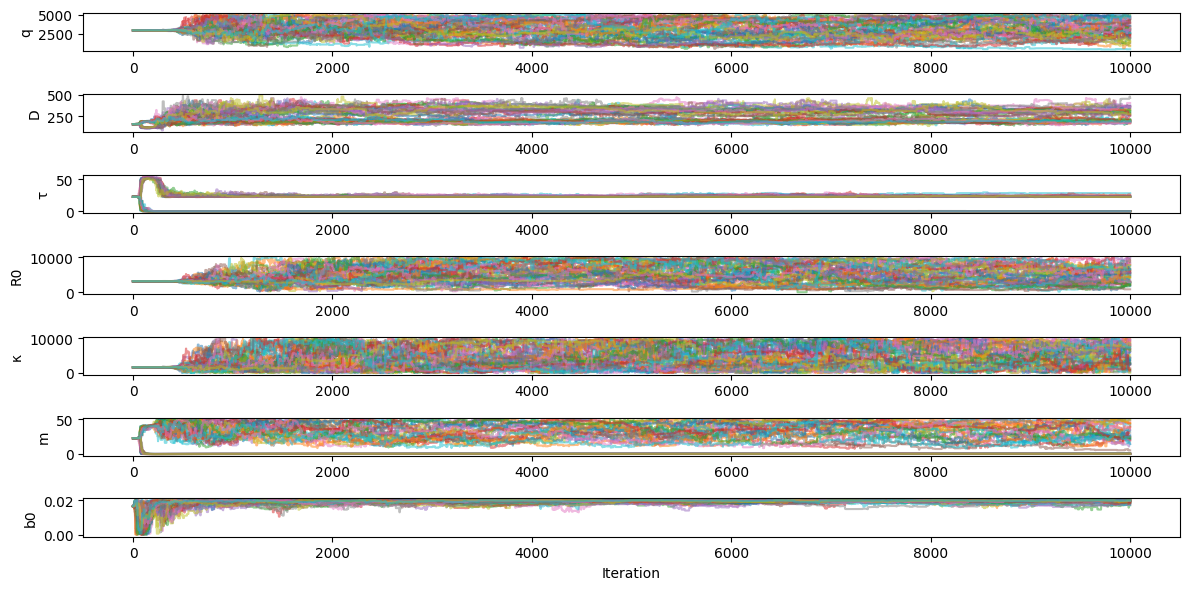

In [71]:
# Trace Plots
plt.figure(figsize=(12, 6))
for dim in range(ndim):
    plt.subplot(ndim, 1, dim + 1)
    for walker in range(n_walkers):
        plt.plot(chains[:, walker, dim], alpha=0.5)
    plt.ylabel(labels[dim])
plt.xlabel("Iteration")
plt.tight_layout()
# plt.savefig("Figures/Chains for control_1.pdf")
plt.show()

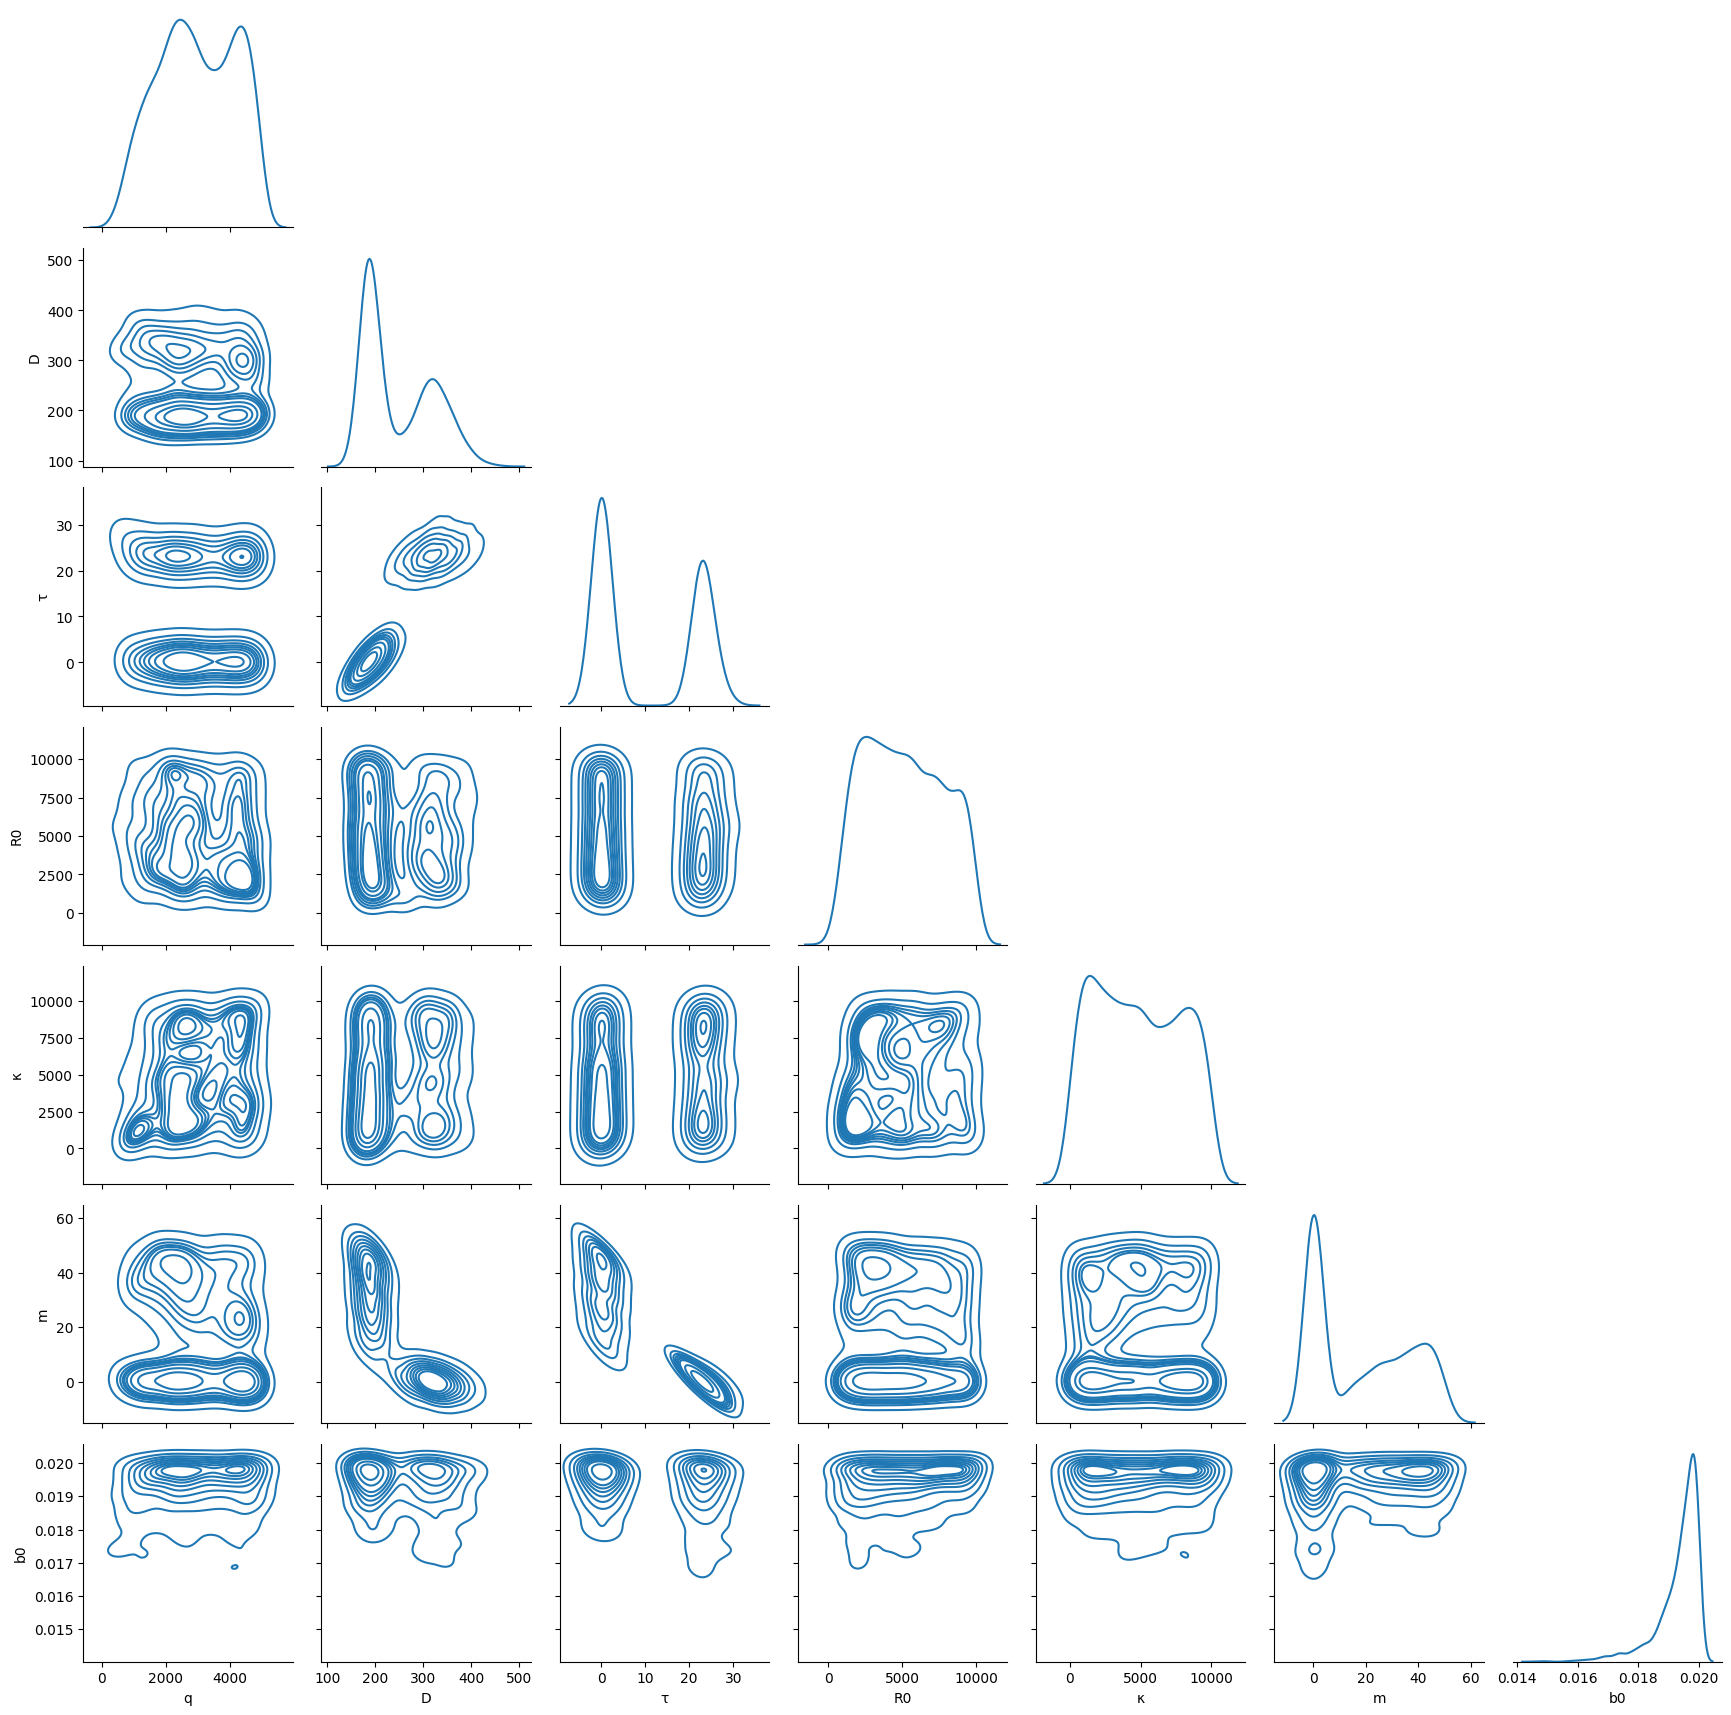

In [72]:
# chains = Post_attractant_control[0].get_chain(discard=5000, thin=50)
chains = Post_attractant_control[0].get_chain(discard=5000, thin=100)

# Pairwise Scatter Plots
labels = [labels[dim] for dim in range(ndim)]
samples_df = pd.DataFrame(data=chains[:, :, :ndim].reshape(-1, ndim), columns=labels)

g = sns.PairGrid(samples_df, diag_sharey=False, corner=True)
# g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)


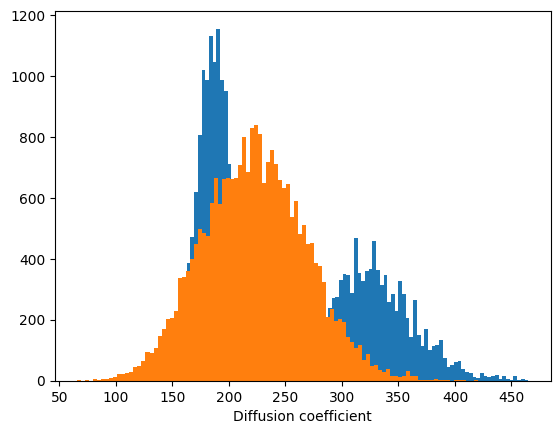

In [73]:
chains_mcr = Post_attractant_mcr[0].get_chain(discard=5000, thin=10, flat = True)
chains_control = Post_attractant_control[0].get_chain(discard=5000, thin=10, flat = True)
#chains_mcr
plt.hist(chains_control[:,1], bins = 100)
plt.hist(chains_mcr[:,1], bins = 100)

plt.xlabel("Diffusion coefficient")
plt.show()

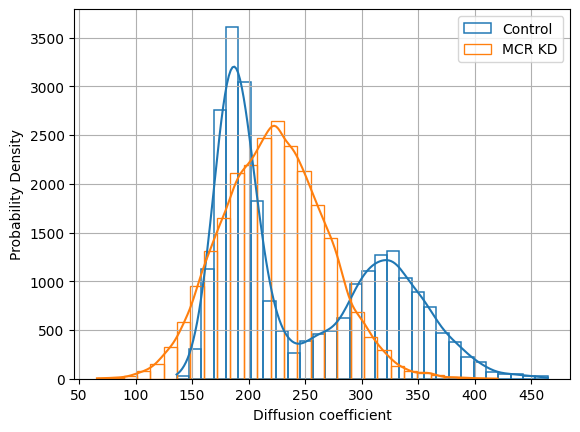

In [74]:
import seaborn as sns

# Create a histogram plot with seaborn
sns.histplot(chains_control[:,1],fill =False, kde=True, bins=30, label='Control')
sns.histplot(chains_mcr[:,1],fill =False,  kde=True,bins=30, label='MCR KD')

# Customize the plot
plt.xlabel('Diffusion coefficient')
plt.ylabel('Probability Density')
# plt.title('Probability Density Plot')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

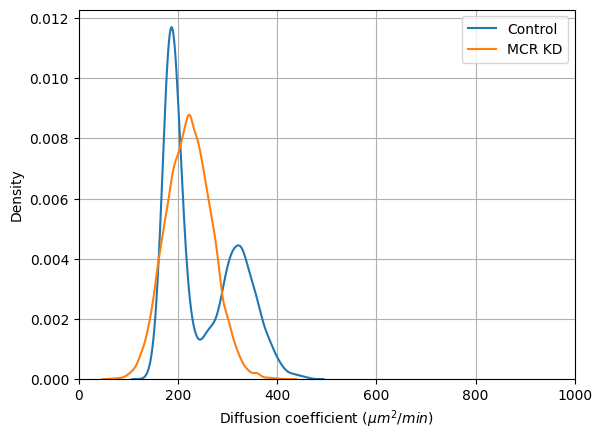

In [75]:
# Create a histogram plot with seaborn
sns.kdeplot(chains_control[:,1],label='Control')
sns.kdeplot(chains_mcr[:,1], label='MCR KD')

# Customize the plot
plt.xlabel('Diffusion coefficient ($\mu m^2/min$)')
plt.ylabel('Density')
plt.xlim([0,1000])
plt.legend()
plt.grid(True)
plt.savefig("Figures/Diffusion_coefficients.pdf")

# Show the plot
plt.show()

In [76]:
d = {'Diffusion-control': chains_control[:,1], 'Diffusion-mcr': chains_mcr[:,1], 'ProductionTime-control':chains_control[:,2], 'ProductionTime-mcr':chains_mcr[:,2]}
Posteriors = pd.DataFrame(data=d)

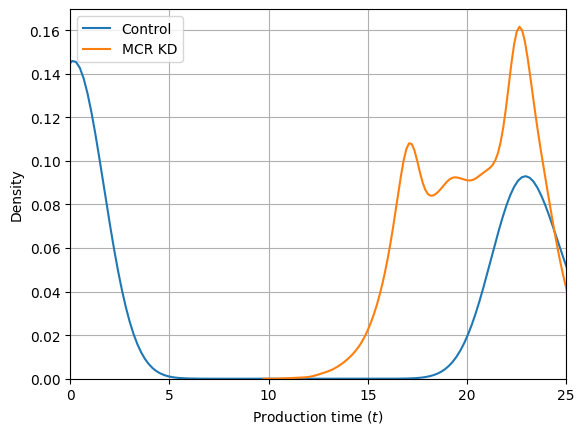

In [77]:
# Create a histogram plot with seaborn
sns.kdeplot(chains_control[:,2],label='Control')
sns.kdeplot(chains_mcr[:,2], label='MCR KD')

# Customize the plot
plt.xlabel('Production time ($t$)')
plt.ylabel('Density')
plt.xlim([0,25])
plt.legend()
plt.grid(True)
plt.savefig("Figures/Production_time.pdf")

# Show the plot
plt.show()

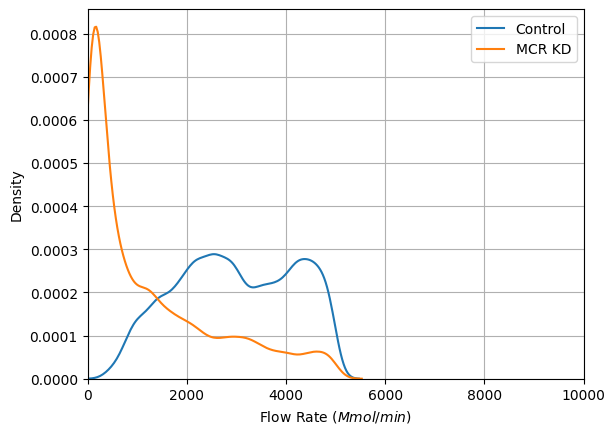

In [78]:
# Create a histogram plot with seaborn
sns.kdeplot(chains_control[:,0],label='Control')
sns.kdeplot(chains_mcr[:,0], label='MCR KD')

# Customize the plot
plt.xlabel('Flow Rate ($Mmol / min$)')
plt.ylabel('Density')
plt.xlim([0,10000])
plt.legend()
plt.grid(True)
plt.savefig("SI_flow_rate.pdf")

# Show the plot
plt.show()
# Check low flow rate at diffusivity for MCR 